## Setup PySpark

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, unix_timestamp, lag, when, avg, to_timestamp
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier

## Init Spark

In [2]:
spark = SparkSession.builder.appName("CryptoTradingBot").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/02 12:28:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Load Data

In [13]:
from elasticsearch import Elasticsearch

es = Elasticsearch(hosts=["http://localhost:9200"])

response = es.search(index="historical", body={
    "query": {
        "match_all": {}
    },
    "size": 1000  
})

data = [hit["_source"] for hit in response["hits"]["hits"]]

spark = SparkSession.builder.appName("CryptoTradingBot").getOrCreate()

training_df = spark.createDataFrame(data)

training_df.head()

Row(price='95146.52000000', symbol='btcusdt', time='2024-12-29T11:42:13.653000')

In [14]:
training_df.printSchema()

root
 |-- price: string (nullable = true)
 |-- symbol: string (nullable = true)
 |-- time: string (nullable = true)



## Convert Data

In [15]:
training_df = training_df.withColumn("time", to_timestamp(col("time")))

training_df = training_df.withColumn("time_numeric", unix_timestamp(col("time")))

training_df = training_df.withColumn("price", col("price").cast("double"))

training_df.head(2)

[Row(price=95146.52, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 13, 653000), time_numeric=1735472533),
 Row(price=95146.52, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 14, 824000), time_numeric=1735472534)]

In [16]:
training_df.printSchema()

root
 |-- price: double (nullable = true)
 |-- symbol: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- time_numeric: long (nullable = true)



In [17]:
window_spec = Window.orderBy("time_numeric")
training_df = training_df.withColumn("prev_price", lag("price", 1).over(window_spec))
training_df.head(2)


25/02/02 12:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:33:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


[Row(price=95146.52, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 13, 653000), time_numeric=1735472533, prev_price=None),
 Row(price=95146.52, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 14, 824000), time_numeric=1735472534, prev_price=95146.52)]

In [18]:
training_df = training_df.withColumn("label", when(col("price") > col("prev_price"), 1).otherwise(0))
training_df = training_df.na.drop()
training_df.head(2)

25/02/02 12:33:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:33:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:33:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:33:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:33:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


[Row(price=95146.52, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 14, 824000), time_numeric=1735472534, prev_price=95146.52, label=0),
 Row(price=95147.64, symbol='btcusdt', time=datetime.datetime(2024, 12, 29, 11, 42, 17, 836000), time_numeric=1735472537, prev_price=95146.52, label=1)]

In [19]:
assembler = VectorAssembler(inputCols=["time_numeric", "prev_price"], outputCol="features")
training_df = training_df.select("time_numeric", "prev_price", "label")
training_df = assembler.transform(training_df).select("features", "label")

In [20]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
model = rf.fit(training_df)

25/02/02 12:36:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:19 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 1

In [21]:
predictions = model.transform(training_df)
predictions.select("features", "label", "prediction").show()

25/02/02 12:36:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:36:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|[1.735472534E9,95...|    0|       1.0|
|[1.735472537E9,95...|    1|       1.0|
|[1.735472537E9,95...|    0|       1.0|
|[1.735472537E9,95...|    1|       1.0|
|[1.735472539E9,95...|    1|       1.0|
|[1.73547254E9,951...|    0|       1.0|
|[1.73547254E9,951...|    0|       1.0|
|[1.73547254E9,951...|    0|       1.0|
|[1.73547254E9,951...|    0|       1.0|
|[1.735472566E9,95...|    1|       1.0|
|[1.735472566E9,95...|    1|       1.0|
|[1.735472576E9,95...|    0|       1.0|
|[1.735472576E9,95...|    0|       1.0|
|[1.735472588E9,95...|    1|       1.0|
|[1.735472588E9,95...|    1|       1.0|
|[1.735472589E9,95...|    1|       1.0|
|[1.735472592E9,95...|    1|       1.0|
|[1.735472594E9,95...|    0|       1.0|
|[1.735472594E9,95...|    1|       1.0|
|[1.735472594E9,95...|    0|       0.0|
+--------------------+-----+----------+
only showing top 20 rows



25/02/02 12:48:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:48:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:48:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:48:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:48:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 12:48:28 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
25/02/02 1

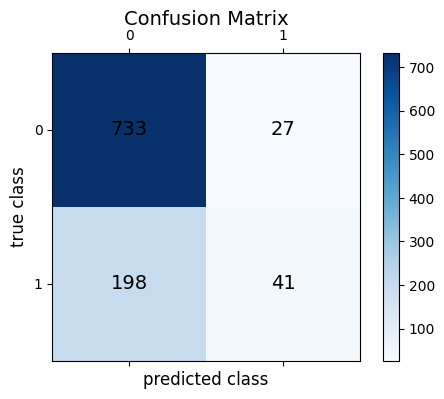

In [27]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import numpy as np


confusion_df = predictions.select("label", "prediction")

TP = confusion_df.filter((col('label') == 1) & (col('prediction') == 1)).count()

TN = confusion_df.filter((col('label') == 0) & (col('prediction') == 0)).count()

FP = confusion_df.filter((col('label') == 0) & (col('prediction') == 1)).count()

FN = confusion_df.filter((col('label') == 1) & (col('prediction') == 0)).count()

conf_matrix = np.array([[TN, FP],
                        [FN, TP]])

fig, ax = plt.subplots(figsize=(6, 4))
cax = ax.matshow(conf_matrix, cmap=plt.cm.Blues)

plt.colorbar(cax)

ax.set_xlabel('predicted class', fontsize=12)
ax.set_ylabel('true class', fontsize=12)
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['0', '1'])
ax.set_yticklabels(['0', '1'])

for (i, j), val in np.ndenumerate(conf_matrix):
    ax.text(j, i, f'{val}', ha='center', va='center', color='black', fontsize=14)

plt.title('Confusion Matrix', pad=20, fontsize=14)

plt.show()

In [28]:
# Accuracy
accuracy = (TP + TN) / (TP + TN + FP + FN)

# Precision
precision = TP / (TP + FP) if (TP + FP) != 0 else 0

# Recall
recall = TP / (TP + FN) if (TP + FN) != 0 else 0

# F1-Score
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Ausgabe der Metriken
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1_score:.2f}")

Accuracy: 0.77
Precision: 0.60
Recall: 0.17
F1-Score: 0.27


In [30]:
# Sell if profit > 5% or loss > 2%
take_profit = 0.05
stop_loss = 0.02

training_df = predictions.withColumn(
    "sell_signal",
    when((col("price") > col("prev_price") * (1 + take_profit)), "SELL")
    .when((col("price") < col("prev_price") * (1 - stop_loss)), "SELL")
    .otherwise("HOLD")
)

training_df.select("time", "price", "sell_signal").show()

AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `price` cannot be resolved. Did you mean one of the following? [`label`, `prediction`, `features`, `probability`, `rawPrediction`].;
'Project [features#101, label#83, rawPrediction#180, probability#187, prediction#198, CASE WHEN ('price > ('prev_price * 1.05)) THEN SELL WHEN ('price < ('prev_price * 0.98)) THEN SELL ELSE HOLD END AS sell_signal#319]
+- Project [features#101, label#83, rawPrediction#180, probability#187, UDF(rawPrediction#180) AS prediction#198]
   +- Project [features#101, label#83, rawPrediction#180, UDF(rawPrediction#180) AS probability#187]
      +- Project [features#101, label#83, UDF(features#101) AS rawPrediction#180]
         +- Project [features#101, label#83]
            +- Project [time_numeric#67L, prev_price#77, label#83, UDF(struct(time_numeric_double_VectorAssembler_a5aabe8ba52d, cast(time_numeric#67L as double), prev_price, prev_price#77)) AS features#101]
               +- Project [time_numeric#67L, prev_price#77, label#83]
                  +- Filter atleastnnonnulls(6, price#72, symbol#58, time#63, time_numeric#67L, prev_price#77, label#83)
                     +- Project [price#72, symbol#58, time#63, time_numeric#67L, prev_price#77, CASE WHEN (price#72 > prev_price#77) THEN 1 ELSE 0 END AS label#83]
                        +- Project [price#72, symbol#58, time#63, time_numeric#67L, prev_price#77]
                           +- Project [price#72, symbol#58, time#63, time_numeric#67L, prev_price#77, prev_price#77]
                              +- Window [lag(price#72, -1, null) windowspecdefinition(time_numeric#67L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS prev_price#77], [time_numeric#67L ASC NULLS FIRST]
                                 +- Project [price#72, symbol#58, time#63, time_numeric#67L]
                                    +- Project [cast(price#57 as double) AS price#72, symbol#58, time#63, time_numeric#67L]
                                       +- Project [price#57, symbol#58, time#63, unix_timestamp(time#63, yyyy-MM-dd HH:mm:ss, Some(Etc/UTC), false) AS time_numeric#67L]
                                          +- Project [price#57, symbol#58, to_timestamp(time#59, None, TimestampType, Some(Etc/UTC), false) AS time#63]
                                             +- LogicalRDD [price#57, symbol#58, time#59], false


In [7]:
spark.stop()